# Importation des bibliothèques

In [1]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Calcul du temps nécessaire à la création des datasets

In [2]:
# Calcul du temps pour générer les dataframes : 

def time_displayer(elapsed_time):
    elapsed_time = int(round(elapsed_time, 0))
    h = elapsed_time // 3600
    elapsed_time = elapsed_time - (h*3600)
    m = elapsed_time // 60
    elapsed_time = elapsed_time - (m*60)
    h_texte = "heures" if h > 1 else "heure"
    m_texte = "minutes" if m > 1 else "minute"
    s_texte = "secondes" if elapsed_time > 1 else "seconde"
    if h > 0:
        return f"Temps d'exécution : {str(h).zfill(2)} {h_texte} {str(m).zfill(2)} {m_texte} {str(elapsed_time).zfill(2)} {s_texte}"
    elif m > 0:
        return f"Temps d'exécution : {str(m).zfill(2)} {m_texte} {str(elapsed_time).zfill(2)} {s_texte}"
    else:
        return f"Temps d'exécution : {str(elapsed_time).zfill(2)} {s_texte}"

## Définition des caractéristiques d'un prêt

In [3]:
# On définit les caractéristiques du prêt :
capital = int(input("Quel est le montant souhaité de l'emprunt ?  "))
duree = int(input("Quelle est la durée souhaitée de l'emprunt ? ( en annéees )  "))
taux_interet_annuel = float(input("Quel est le taux d'intérêt annuel pour l'emprunt ?  "))
age_souscription = int(input("Quel est l'âge de l'emprunteur à la souscription du prêt ?  "))
taux_technique_annuel = float(input("Quel est le taux technique annuel ?  "))

Quel est le montant souhaité de l'emprunt ?   200000
Quelle est la durée souhaitée de l'emprunt ? ( en annéees )   020
Quel est le taux d'intérêt annuel pour l'emprunt ?   0.0375
Quel est l'âge de l'emprunteur à la souscription du prêt ?   45
Quel est le taux technique annuel ?   0.015


## Fonction qui applique l'abattement sur la table de mortalité de départ (TH00-02)

In [3]:
# Je crée une fonction qui applique l'abattement sur la table de mortalité de départ : 
def abattement(table_mortalite,  taux_abattement):
    # Abattement sur les qx
    table_mortalite["qx"] = table_mortalite["qx"] * (1 - taux_abattement)
    table_mortalite.at[table_mortalite.index[-1], "qx"] = 1.00 # Mettre la dernière valeur de qx à 100%


    # S'assurer que lx est en float
    table_mortalite["lx"] = table_mortalite["lx"].astype(float)
    
    # Propagation ligne par ligne
    for i in range(1, len(table_mortalite)):
        table_mortalite.loc[i, "lx"] = table_mortalite.loc[i-1, "lx"] * (1 - table_mortalite.loc[i-1, "qx"])
    
    return table_mortalite

In [4]:
# J'applique l'abattement sur la table de mortalité de départ (TH00-02) :
#taux_abattement = float(input("Quel est le taux d'abattement souhaité à appliquer sur la table de mortalité ?  "))
taux_abattement = 0.35 # Valeur par défaut

table_mortalite_avec_abattement = abattement(pd.read_excel("TH00-02.xlsx"), taux_abattement)

## Fonction qui calcule la prime mensuelle d'assurance pour un prêt donné (en fonction de ses caractéristiques)

In [5]:
def compute_mensual_premium_direct(table_mortalite, capital, duree, taux_emprunt_annuel, age, taux_technique_annuel):

    # Création du tableau d'amortissement :
    def creer_tableau_amortissement(capital, duree, taux_emprunt_annuel):     
        # Calcul de la mensualité fixe
        mensualite = capital * ((taux_emprunt_annuel / 12) / (1 - (1 + taux_emprunt_annuel / 12) ** (-12 * duree)))
        
        nbr_mensualites = 12 * duree
        
        # Listes pour stocker les données
        capital_restant_du = [capital]  # première ligne = capital initial
        interets = [0]
        mensualites = [0]
        capital_rembourse = [0]
        
        # Boucle pour calculer chaque mensualiténbr_mensualites = int(12 * float(duree))
        for m in range(1, nbr_mensualites + 1):
            interet = capital_restant_du[m-1] * (taux_emprunt_annuel / 12)
            capital_r = mensualite - interet
            capital_rest = capital_restant_du[m-1] - capital_r
            
            interets.append(round(interet, 2))
            mensualites.append(round(mensualite, 2))
            capital_rembourse.append(round(capital_r, 2))
            capital_restant_du.append(round(capital_rest, 2))
        
        # Création du DataFrame
        df_amortissement = pd.DataFrame({
            "Num_échéance": range(nbr_mensualites + 1),
            "capital_restant_du": capital_restant_du,
            "interets": interets,
            "mensualites": mensualites,
            "capital_rembourse": capital_rembourse
        })
        
        return df_amortissement

    # Je crée une fonction qui va directement nous retournons un df avec comme colonnes : 
    ## - t : les mensualités de 0 à (duree*12)-1
    ## - y(t) : l'âge en années du souscripteur
    ## - x(t) : l'âge exact du souscripteur
    ## - l(y(t)) : l de l'âge en années (donc les l_x anuels)
    ## - l(x(t)) : l interpolé (donc les l_t mensuels)
    ## - q(y(t)) : taux de mortalité de l'âge en années
    ## - q(x(t)) : taux de mortalité de l'âge interpolé
    ## - tp[x(0)] : la proba qu'à l'âge x(0) l'individu survive t mensualités supplémentaires
    ## - facteur_actu : le facteur d'actualisation
    ## - Perte : Perte à la mensualité t
    ## - CRD : le capital restant dû à la mensualité t sachant qu'à t=1 CDR = L
    
    def create_data_frame(age, table_mortalite, duree, taux_technique_annuel, CRD):
        # Colonnes du DataFrame
        colonnes = ["t", "y(t)", "x(t)", "l(y(t))", "l(x(t))", "q(y(t))", "q(x(t))", "tp[x(0)]", "facteur_actu", "Perte", "CRD"]
        df = pd.DataFrame(columns=colonnes)
    
        # t en mois
        df["t"] = range(0, 12 * duree+1)
        # y(t) = âge arrondi à l'année
        df["y(t)"] = age + df["t"] // 12
        # x(t) = âge exact mois par mois
        df["x(t)"] = age + df["t"] / 12
    
        # Récupérer lx annuel pour l(y(t))
        temp = table_mortalite[["Age", "lx"]].rename(columns={"lx": "l_temp"})
        df = df.merge(
            temp,
            left_on="y(t)",
            right_on="Age",
            how="left")
        
        df["l(y(t))"] = df["l_temp"]
        df.drop(columns=["Age", "l_temp"], inplace=True)
    
        # --- Remplissage de l(x(t)) par interpolation linéaire mensuelle ---
        # Interpolation linéaire    
        # age_floor = année entière correspondante pour chaque mois
        age_floor = (df["t"] // 12).astype(int)
        
        # fraction d'année écoulée pour chaque mois
        frac = (df["t"] / 12 - age_floor)
        
        # lx0 = l(y(t)) de l'année en cours
        lx0 = df["l(y(t))"].values[age_floor * 12] if hasattr(df["l(y(t))"].values[age_floor * 12], "__iter__") else df["l(y(t))"].values[age_floor * 12]
        
        # lx1 = l(y(t)) de l'année suivante
        # On s'assure de ne pas dépasser la dernière valeur
        last_index = len(df) - 1
        idx1 = np.minimum(age_floor * 12 + 12, last_index)
        lx1 = df["l(y(t))"].values[idx1]
        
        # interpolation linéaire
        df["l(x(t))"] = lx0 + frac * (lx1 - lx0)
    
        # Créer un dictionnaire âge → qx
        qx_dict = table_mortalite.set_index("Age")["qx"].to_dict()
        
        # Appliquer qx correspondant à y(t)
        df["q(y(t))"] = df["y(t)"].map(qx_dict)
    
        df["q(x(t))"] = (df["l(x(t))"] - df["l(x(t))"].shift(-1)) / df["l(x(t))"]
    
        df["tp[x(0)]"] = df["l(x(t))"] / df.loc[0, "l(x(t))"]
    
        taux_technique_mensuel = (1 + taux_technique_annuel)**(1/12) - 1
        df["facteur_actu"] = 1 / (1 + taux_technique_mensuel)**(df["t"]+0.5)
    
        df["CRD"] = CRD.values
    
        df["Perte"] = df["CRD"] * df["tp[x(0)]"] * df["q(x(t))"] * df["facteur_actu"]
    
        # On supprime la dernière ligne du df pour avoir bien 12*n valeurs de t où n = durée du prêt en années
        df = df.iloc[:-1]
    
        return df

    # Fonction qui calcule la Prime Unique :
    def compute_single_premium(df):
        return float(df["Perte"].sum())

    # Maintenant il va falloir calculer la facteur d'annuité ( dénominateur de la fraction qui va nous donner la valeur de la prime mensuelle )
    def compute_annuity_factor(df, taux_technique_annuel):
        # Il suffit de calculer le facteur d'actualisation :
        df["actu_factor_annuity"] = (1 / ( (1 + taux_technique_annuel)**(1/12) ))**df["t"]
    
        return float((df["tp[x(0)]"]*df["actu_factor_annuity"]).sum())

    def compute_mensual_premium(U, annuity_factor):
        return U/annuity_factor

    ##############################
    #### Corps de la fonction ####
    ##############################

    # Je calcule le tableau d'amortissement :
    tableau_amortissement = creer_tableau_amortissement(capital, duree, taux_emprunt_annuel)

    # Je crée le Data Frame avec les données nécessaires au calcul de la prime Unique :
    df = create_data_frame(age, table_mortalite, duree, taux_technique_annuel, tableau_amortissement["capital_restant_du"])

    # Je calcule la prime mensuelle :
    prime_mensuelle = compute_mensual_premium(compute_single_premium(df), compute_annuity_factor(df, taux_technique_annuel))

    return prime_mensuelle

In [7]:
# Calcul de la prime mensuelle pour les caractéristiques du prêt renseignées au départ : 
prime_mensuelle_directe = compute_mensual_premium_direct(table_mortalite_avec_abattement, capital, duree, taux_interet_annuel, age_souscription, taux_technique_annuel)
prime_mensuelle_directe

42.86489789673503

In [6]:
# Vérifications de la prime mensuelle calculée avec des caractéristiques d'un prêt connus et dont la prime a été calculée en Excel :
prime_mensuelle_directe = compute_mensual_premium_direct(table_mortalite_avec_abattement, 200000, 20, 0.0375, 45, 0.015)
prime_mensuelle_directe

42.86489789673503

# Création du dataset

### Création d'une fonction qui va simuler un nombre N de prêts bancaires, aléatoires

In [1]:
# Maintenant je génère le dataset : 
## - capital_emprunte : Montant aléatoire, entier, compris entre 50k et 500k (pas de 5k en 5k)
## - duree : Variable aléatoire entière parmi [5, 10, 15, 20, 25]
## - age_souscription : Variable aléatoire entière, comprise entre 18 et 60 ans inclus
## - taux_interet_annuel : Taux aléatoire compris entre 0.5% et 4.5%
## - taux_technique_annuel : Taux aléatoire compris entre 0.5% et 2.0%
# Je répartis équitablement mes données (distribution uniforme des valeurs des variables "capital_emprunte" et "age_souscription"

In [8]:
def generate_loan_dataset(n_obs, random_state=42):
    np.random.seed(random_state)
    
    # -------------------------
    # Age du souscripteur
    # -------------------------
    age_souscription = np.random.randint(18, 61, size=n_obs)
    
    # -------------------------
    # Durée
    # -------------------------
    durees_possibles = np.array([5, 10, 15, 20, 25])
    duree = np.random.choice(durees_possibles, size=n_obs)
    
    # -------------------------
    # Capital emprunté : uniformité exacte
    # -------------------------
    capital_values = np.arange(50000, 550001, 5000)  # 50k → 550k
    n_values = len(capital_values)
    
    # Répéter chaque valeur autant de fois que nécessaire pour atteindre n_obs
    repeats = n_obs // n_values
    remainder = n_obs % n_values
    
    capital_emprunte = np.tile(capital_values, repeats)  # répète toutes les valeurs
    if remainder > 0:
        # Ajoute les valeurs restantes au hasard
        capital_emprunte = np.concatenate([capital_emprunte, np.random.choice(capital_values, remainder, replace=False)])
    
    # Mélanger pour que l'ordre soit aléatoire
    np.random.shuffle(capital_emprunte)
    
    # -------------------------
    # Taux d'intérêt annuel
    # -------------------------
    taux_interet_annuel = np.round(np.random.uniform(0.005, 0.045, size=n_obs), 3)
    
    # -------------------------
    # Taux technique annuel
    # -------------------------
    taux_technique_annuel = np.round(np.random.uniform(0.005, 0.02, size=n_obs), 3)
    
    # -------------------------
    # DataFrame final
    # -------------------------
    df = pd.DataFrame({
        "age_souscription": age_souscription,
        "duree": duree,
        "capital_emprunte": capital_emprunte,
        "taux_interet_annuel": taux_interet_annuel,
        "taux_technique_annuel": taux_technique_annuel
    })
    
    return df

### Génération des données (variables explicatives // features)

In [9]:
# Combien de prêts souhaite-t-on simuler ? :
nombre_observations = int(input("Combiend'observations faut-il créer pour le dataset ?"))

Combiend'observations faut-il créer pour le dataset ? 100


In [10]:
# On crée un data frame avec 'nombre_observations' prêts simulés
start_time = time.time()  # Début du chronomètre

dataset = generate_loan_dataset(n_obs=nombre_observations, random_state=42)

end_time = time.time()  # Fin du chronomètre
elapsed_time = end_time - start_time  # Temps écoulé en secondes
print(time_displayer(elapsed_time))

Temps d'exécution : 00 seconde


### Calcul de la cible (target // y_true) associée à chaque observation (à chaque prêt simulé)

In [11]:
# Ensuite pour chaque observation du dataset on calcule la target (le y_true), donc la prime mensuelle, qu'on ajoute en dernière colonne du dataset :

In [12]:
start_time = time.time()  # Début du chronomètre

for i in range(len(dataset)):
    #print(i) # Pour savoir à quelle observartion on est rendu et suivre l'avancement
    dataset.loc[i, "target"] = compute_mensual_premium_direct(
        table_mortalite_avec_abattement,
        int(dataset.loc[i, "capital_emprunte"]),
        int(dataset.loc[i, "duree"]),
        float(dataset.loc[i, "taux_interet_annuel"]),
        int(dataset.loc[i, "age_souscription"]),
        float(dataset.loc[i, "taux_technique_annuel"])
         )

end_time = time.time()  # Fin du chronomètre
elapsed_time = end_time - start_time  # Temps écoulé en secondes
print(time_displayer(elapsed_time))

Temps d'exécution : 00 seconde


#### Enregistrement du dataset dans un fichier csv

In [2]:
# Enregistrement du dataset dans un fichier csv (nécessaire que lors de la création des datasets) :
#n_rows = dataset.shape[0]

#nom_fichier = f"dataset_{n_rows}_lignes_random.csv" # Format du nom du fichier : "dataset_NombreObservations_lignes.csv"
#dataset.to_csv(nom_fichier, index=False)
#print("Fichier enregistré")

### Ouverture d'un dataset (d'un fichier csv avec nos features et la target associée, pour chaque observation)

In [20]:
# Lecture du data set (soforme de fichier .csv pour le ML)
dataset = pd.read_csv("dataset_40000_lignes_random.csv")

In [21]:
# Affichage de mon dataset
#dataset

## Machine Learning

## Analyses des features

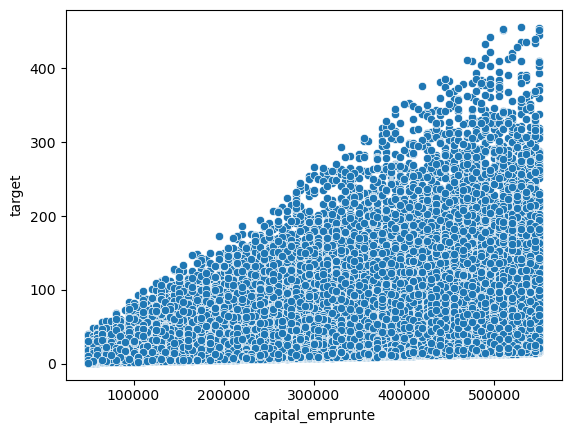

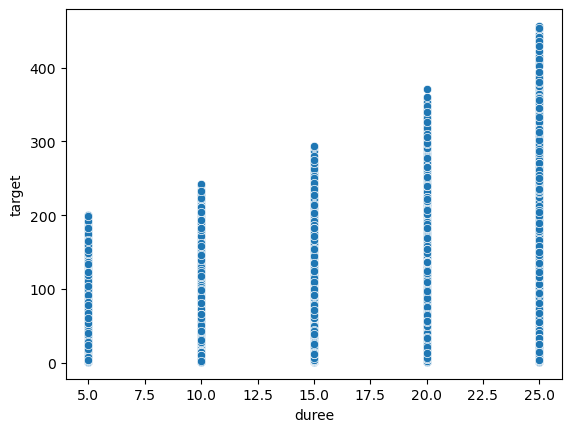

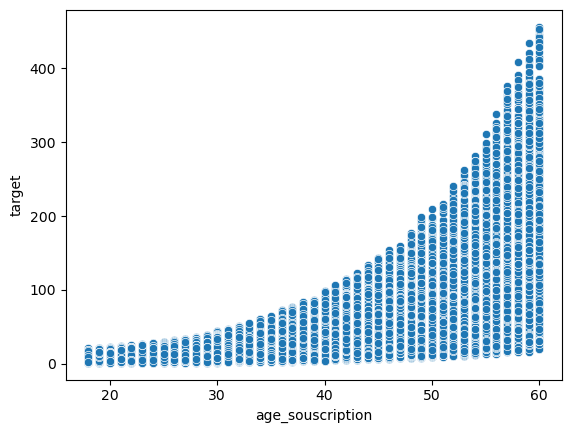

In [22]:
for col in ["capital_emprunte", "duree", "age_souscription"]:
    sns.scatterplot(x=dataset[col], y=dataset["target"])
    plt.show()

## Régression Linéaire (benchmark)

Train : MSE 991.31, MAE 22.34, R² 0.711
Test : MSE 986.58, MAE 22.48, R² 0.703


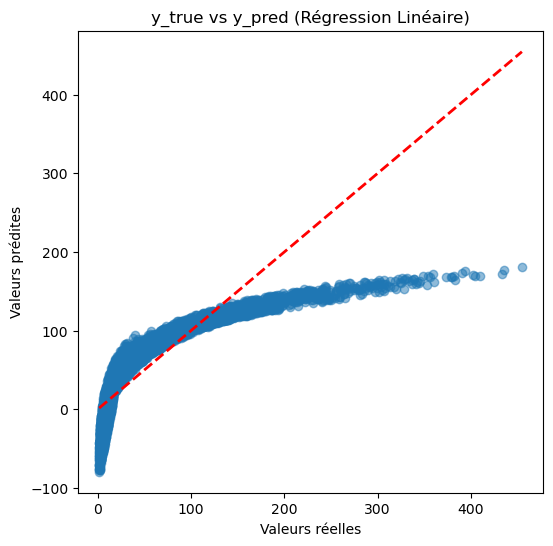

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Features et target
# -------------------------
features_list = [
    "age_souscription",
    "duree",
    "capital_emprunte",
    "taux_interet_annuel",
    "taux_technique_annuel"
]

X = dataset[features_list].to_numpy()
y = dataset["target"].to_numpy()

# -------------------------
# Train test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# Régression Linéaire (benchmark)
# -------------------------
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

# -------------------------
# Prédictions
# -------------------------
y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)

# -------------------------
# Métriques
# -------------------------
print("Train : MSE {:.2f}, MAE {:.2f}, R² {:.3f}".format(
    mean_squared_error(y_train, y_pred_train),
    mean_absolute_error(y_train, y_pred_train),
    r2_score(y_train, y_pred_train)
))
print("Test : MSE {:.2f}, MAE {:.2f}, R² {:.3f}".format(
    mean_squared_error(y_test, y_pred_test),
    mean_absolute_error(y_test, y_pred_test),
    r2_score(y_test, y_pred_test)
))

# -------------------------
# Graphique y_true vs y_pred
# -------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("y_true vs y_pred (Régression Linéaire)")
plt.show()

## Notre modèle à nous, plus poussé et plus performant : RandomForestRegressor

Train : MSE 0.90, MAE 0.44, R² 1.000
Test : MSE 3.66, MAE 0.88, R² 0.999


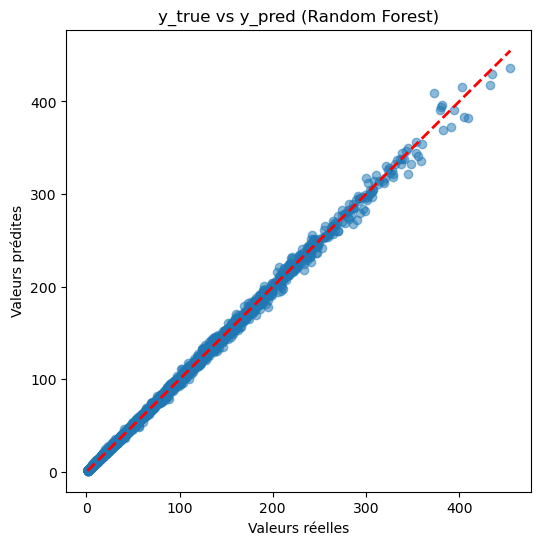

In [24]:
# -------------------------
# Features et target
# -------------------------
features_list = [
    "age_souscription",
    "duree",
    "capital_emprunte",
    "taux_interet_annuel",
    "taux_technique_annuel"
]

X = dataset[features_list].to_numpy()
y = dataset["target"].to_numpy()

# -------------------------
# Train Test Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# Modèle : Random Forest Regressor
# -------------------------
model_rf = RandomForestRegressor(
    n_estimators=500,      # plus d'arbres pour plus de précision
    max_depth=None,        # profondeur illimitée
    min_samples_leaf=2,    # évite overfitting extrême
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

# -------------------------
# Prédictions
# -------------------------
y_pred_train = model_rf.predict(X_train)
y_pred_test = model_rf.predict(X_test)

# -------------------------
# Métriques
# -------------------------
print("Train : MSE {:.2f}, MAE {:.2f}, R² {:.3f}".format(
    mean_squared_error(y_train, y_pred_train),
    mean_absolute_error(y_train, y_pred_train),
    r2_score(y_train, y_pred_train)
))
print("Test : MSE {:.2f}, MAE {:.2f}, R² {:.3f}".format(
    mean_squared_error(y_test, y_pred_test),
    mean_absolute_error(y_test, y_pred_test),
    r2_score(y_test, y_pred_test)
))

# -------------------------
# Graphique y_true vs y_pred
# -------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("y_true vs y_pred (Random Forest)")
plt.show()

In [25]:
# -------------------------
# Fonction pour prédiction sur une nouvelle donnée
# -------------------------
def predict_new_loan(model, age, duree, capital, taux_interet, taux_technique):
    X_new = np.array([[age, duree, capital, taux_interet, taux_technique]])
    y_pred = model.predict(X_new)
    return y_pred[0]

In [26]:
# Exemple d'utilisation :
# -> On va simuler une prime prédite par le modèle et la comparer avec celle obtenue par le calcul actuariel :

# On saisit les caractéristiques du prêt :
capital = int(input("Quel est le montant souhaité de l'emprunt ?  "))
duree = int(input("Quelle est la durée souhaitée de l'emprunt ? ( en annéees )  "))
taux_interet_annuel = float(input("Quel est le taux d'intérêt annuel pour l'emprunt ?  "))
age_souscription = int(input("Quel est l'âge de l'emprunteur à la souscription du prêt ?  "))
taux_technique_annuel = float(input("Quel est le taux technique annuel ?  "))
print("--------------------------------------------")

example_pred = predict_new_loan(model_rf, age=age_souscription, duree=duree, capital=capital, 
                                taux_interet=taux_interet_annuel, taux_technique=taux_technique_annuel)
print(f"Prédiction prime mensuelle pour ce prêt : {example_pred:.3f}")

prime_mensuelle_directe = compute_mensual_premium_direct(table_mortalite_avec_abattement, capital, duree, taux_interet_annuel, age_souscription, taux_technique_annuel)
print(f"Prime mensuelle actuarielle pour ce prêt : {prime_mensuelle_directe:.3f}")

# Erreur de la prédiction en € :
erreur = abs(prime_mensuelle_directe - example_pred)
print(f"Ecart entre la prédiction et la valeur réelle théorique : {float(erreur):.3f}€")

Quel est le montant souhaité de l'emprunt ?   200000
Quelle est la durée souhaitée de l'emprunt ? ( en annéees )   20
Quel est le taux d'intérêt annuel pour l'emprunt ?   0.0375
Quel est l'âge de l'emprunteur à la souscription du prêt ?   45
Quel est le taux technique annuel ?   0.015


--------------------------------------------
Prédiction prime mensuelle pour ce prêt : 42.454
Prime mensuelle actuarielle pour ce prêt : 42.865
Ecart entre la prédiction et la valeur réelle théorique : 0.411€


## Analyses des performances

### Métriques classiques (MAE, RMSE, R²) :

In [29]:
# -------------------------
# TRAIN
# -------------------------
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# -------------------------
# TEST
# -------------------------
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# -------------------------
# Affichage
# -------------------------
print("----- TRAIN -----")
print(f"MAE  : {mae_train:.4f}")
print(f"RMSE : {rmse_train:.4f}")
print(f"R²   : {r2_train:.4f}")

print("\n----- TEST -----")
print(f"MAE  : {mae_test:.4f}")
print(f"RMSE : {rmse_test:.4f}")
print(f"R²   : {r2_test:.4f}")

----- TRAIN -----
MAE  : 0.4423
RMSE : 0.9472
R²   : 0.9997

----- TEST -----
MAE  : 0.8789
RMSE : 1.9128
R²   : 0.9989


### Analyse des performances sur le train

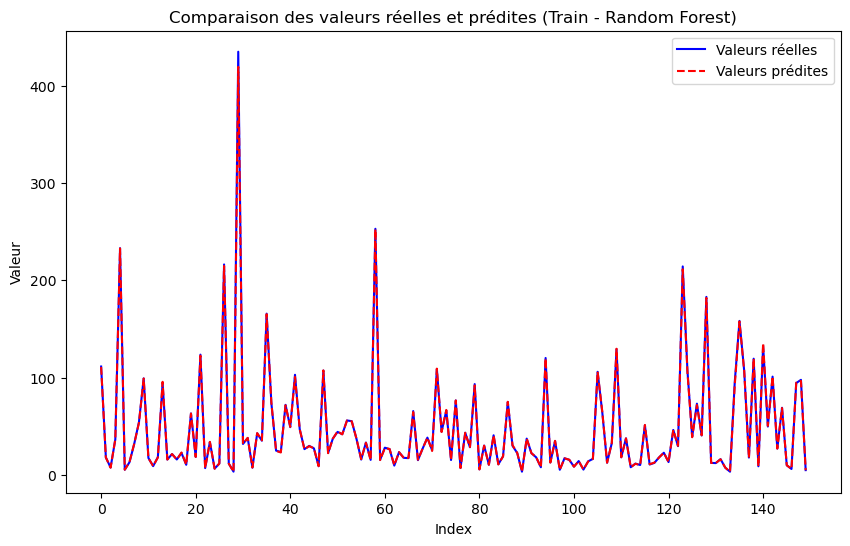

In [27]:
# -------------------------
# Comparaison en courbes (Train)
# -------------------------
plt.figure(figsize=(10, 6))

plt.plot(y_train[500:650],
         label='Valeurs réelles',
         color='blue')

plt.plot(y_pred_train[500:650],
         label='Valeurs prédites',
         color='red',
         linestyle='--')

plt.xlabel('Index')
plt.ylabel('Valeur')
plt.title('Comparaison des valeurs réelles et prédites (Train - Random Forest)')
plt.legend()
plt.show()

###  Analyse des performances sur le test

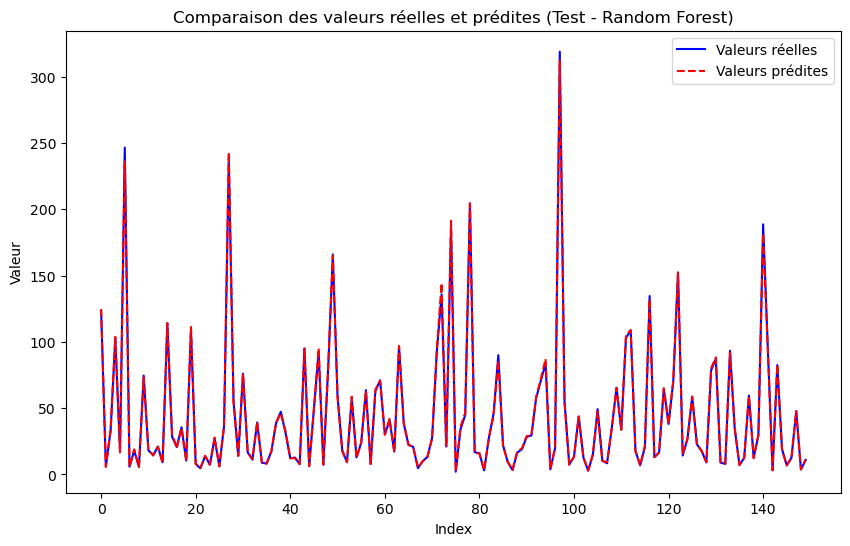

In [28]:
# -------------------------
# Comparaison en courbes (Test)
# -------------------------
plt.figure(figsize=(10, 6))

plt.plot(y_test[200:350],
         label='Valeurs réelles',
         color='blue')

plt.plot(y_pred_test[200:350],
         label='Valeurs prédites',
         color='red',
         linestyle='--')

plt.xlabel('Index')
plt.ylabel('Valeur')
plt.title('Comparaison des valeurs réelles et prédites (Test - Random Forest)')
plt.legend()
plt.show()

### Learning Curve

In [30]:
# -------------------------
# Tailles à tester
# -------------------------
dataset_sizes = [100, 250, 500, 1000, 2500, 5000, 10000, 20000, 30000, 40000, 50000, 75000, 100000]

# Stockage des performances
results = {
    "size": [],
    "mae_train": [],
    "mae_test": [],
    "rmse_train": [],
    "rmse_test": [],
    "r2_train": [],
    "r2_test": []
}

# -------------------------
# Boucle principale
# -------------------------
for n in dataset_sizes:
    
    nom_fichier = f"dataset_{n}_lignes_random.csv" # Format du nom du fichier
    df = pd.read_csv(nom_fichier)
    
    features_list = [
        "age_souscription",
        "duree",
        "capital_emprunte",
        "taux_interet_annuel",
        "taux_technique_annuel"
    ]
    
    X = df[features_list].to_numpy()
    y = df["target"].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    results["size"].append(n)
    results["mae_train"].append(mean_absolute_error(y_train, y_pred_train))
    results["mae_test"].append(mean_absolute_error(y_test, y_pred_test))
    results["rmse_train"].append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    results["rmse_test"].append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    results["r2_train"].append(r2_score(y_train, y_pred_train))
    results["r2_test"].append(r2_score(y_test, y_pred_test))

# Convertir en DataFrame
results_df = pd.DataFrame(results)

In [4]:
#results_df

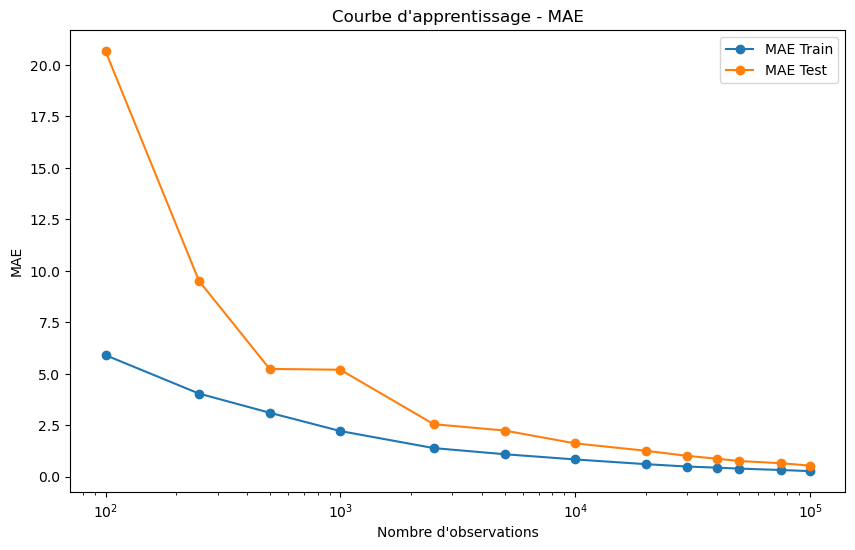

In [32]:
## Avec la MAE :
plt.figure(figsize=(10,6))

plt.plot(results_df["size"], results_df["mae_train"],
         marker='o', label="MAE Train")

plt.plot(results_df["size"], results_df["mae_test"],
         marker='o', label="MAE Test")

plt.xscale("log")

plt.xlabel("Nombre d'observations")
plt.ylabel("MAE")
plt.title("Courbe d'apprentissage - MAE")
plt.legend()
plt.show()

Plus on augmente le nombre d'observations dans notre data set et plus le modèle est capable d'être précis sur ses prédictions et de généraliser cette précision sur le jeu de test également 

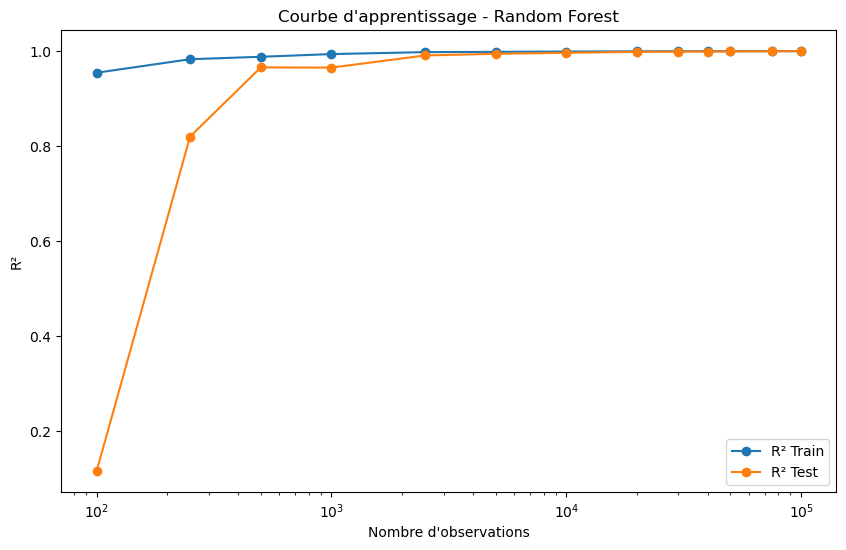

In [33]:
## Avec le R² :
plt.figure(figsize=(10,6))

plt.plot(results_df["size"], results_df["r2_train"],
         marker='o', label="R² Train")

plt.plot(results_df["size"], results_df["r2_test"],
         marker='o', label="R² Test")

plt.xscale("log")  # important pour lisser visuellement

plt.xlabel("Nombre d'observations")
plt.ylabel("R²")
plt.title("Courbe d'apprentissage - Random Forest")
plt.legend()
plt.show()

Avec 500 observations le modèle apprend déjà bien et est capable de généraliser (la learning curve se stabilise)